In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import numpy as np
import os
from PIL import Image
import glob
%matplotlib inline

In [14]:
MAP_NAME = "eight_200px_wide"

# Confirm folder exists
folder_path = f"outputs/{MAP_NAME}"
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Folder not found: {folder_path}")
else:
    print(f"Folder exists: {folder_path}")
    print("Contents:", os.listdir(folder_path))

Folder exists: outputs/eight_200px_wide
Contents: ['traj_race_cl-2025-05-27_15-38-46.csv', 'mintime-2025-05-27_15-38-46']


In [15]:
csv_files = glob.glob(f"outputs/{MAP_NAME}/**/*.csv", recursive=True)
csv_files = sorted(csv_files)
print("CSV files found:", csv_files)

#csv_files

CSV files found: ['outputs/eight_200px_wide/mintime-2025-05-27_15-38-46/accelerations.csv', 'outputs/eight_200px_wide/mintime-2025-05-27_15-38-46/controls.csv', 'outputs/eight_200px_wide/mintime-2025-05-27_15-38-46/lam_g0.csv', 'outputs/eight_200px_wide/mintime-2025-05-27_15-38-46/lam_x0.csv', 'outputs/eight_200px_wide/mintime-2025-05-27_15-38-46/states.csv', 'outputs/eight_200px_wide/mintime-2025-05-27_15-38-46/tire_forces.csv', 'outputs/eight_200px_wide/mintime-2025-05-27_15-38-46/w0.csv', 'outputs/eight_200px_wide/traj_race_cl-2025-05-27_15-38-46.csv']


In [16]:
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in outputs/{MAP_NAME}/")
    
print("Reading CSV:", csv_files[-1])
    
raw_data = pd.read_csv(csv_files[-1], header=None, sep=',')
print("Raw data shape:", raw_data.shape)
print(raw_data.head())
#raw_data

Reading CSV: outputs/eight_200px_wide/traj_race_cl-2025-05-27_15-38-46.csv
Raw data shape: (82, 3)
          0         1         2
0  6.040806  5.024391  1.871079
1  5.907475  4.883713  2.042064
2  5.767297  4.738522  2.133214
3  5.633397  4.592389  1.893564
4  5.509991  4.435447  1.730882


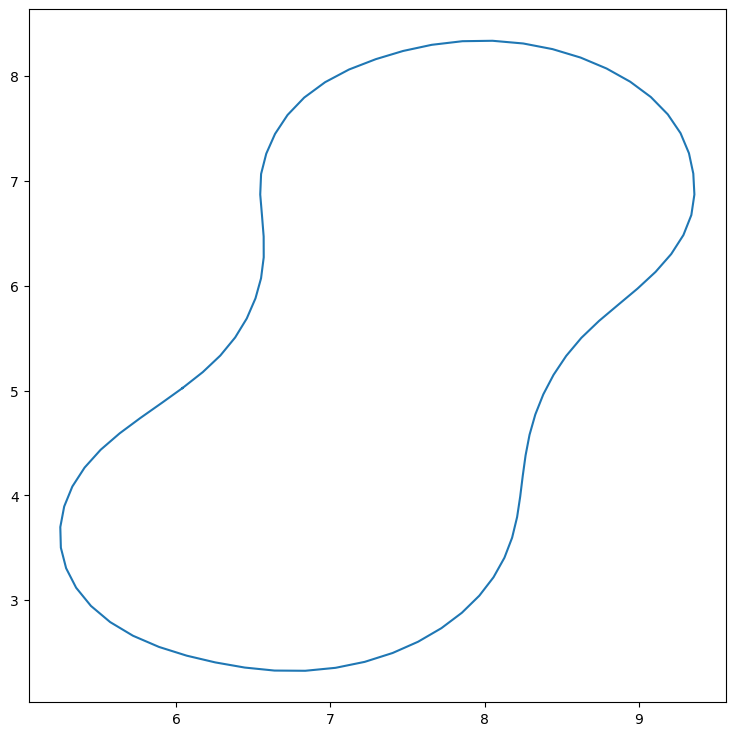

In [17]:
plt.figure(figsize=(9,9))
plt.plot(raw_data.iloc[:, 0], raw_data.iloc[:, 1])

In [18]:
# Overlay the racetrack on the map
# load map yaml
if os.path.exists(f"maps/{MAP_NAME}.png"):
    map_img_path = f"maps/{MAP_NAME}.png"
elif os.path.exists(f"maps/{MAP_NAME}.pgm"):
    map_img_path = f"maps/{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

map_yaml_path = f"maps/{MAP_NAME}.yaml"
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = raw_data.copy()
transformed_data -= np.array([orig_x, orig_y, 0])
transformed_data.iloc[:, :2] /= map_resolution

raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


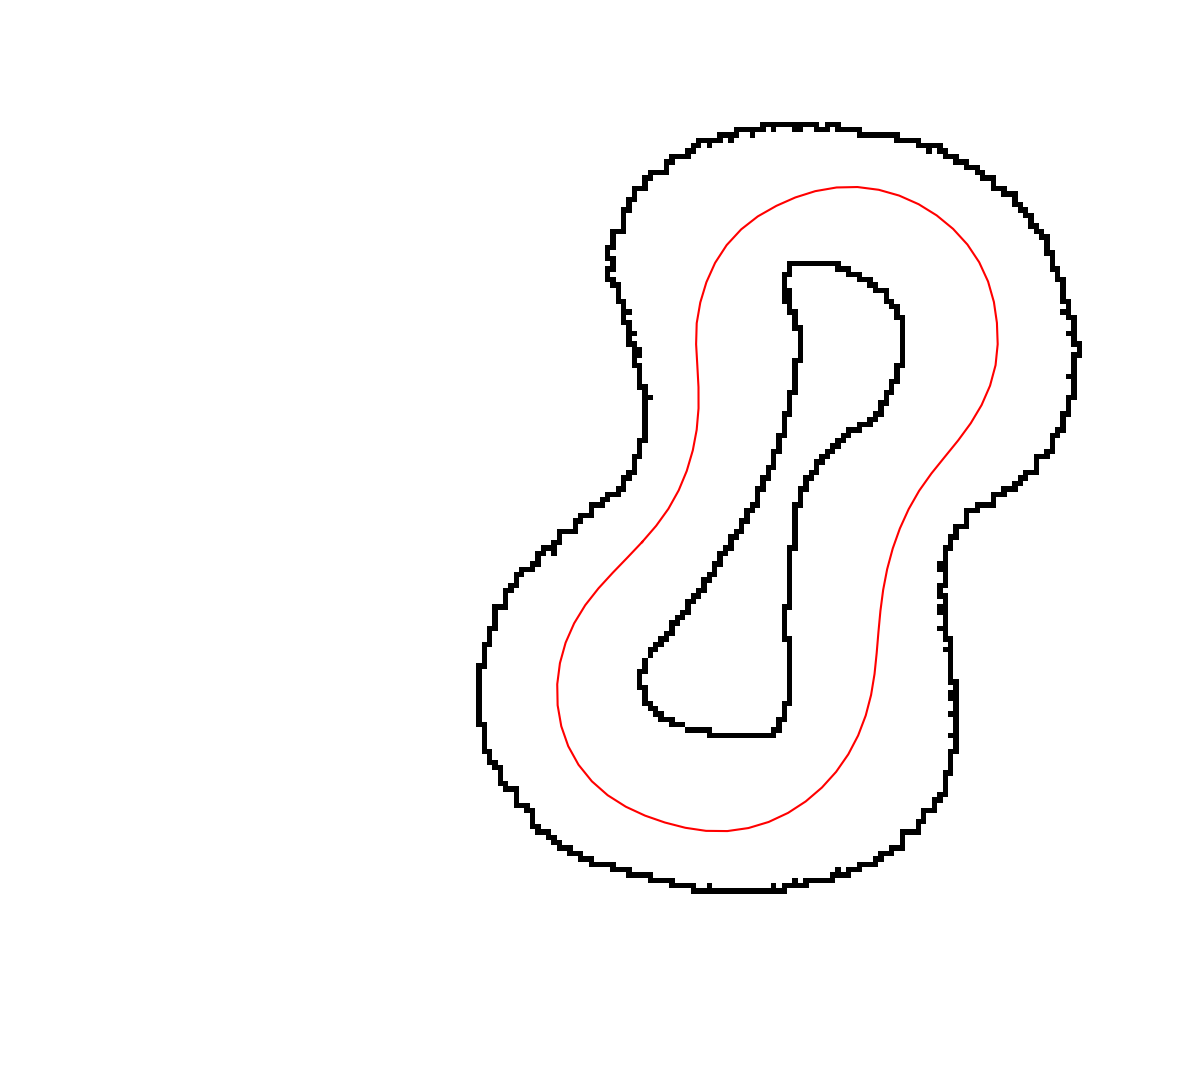

In [19]:
plt.figure(figsize=(15,15))
plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.plot(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], color='red')
# Save image without the axis
plt.axis('off')
plt.savefig(f"outputs/{MAP_NAME}_raceline.png", bbox_inches='tight', pad_inches=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 216.5, -0.5, 198.5)

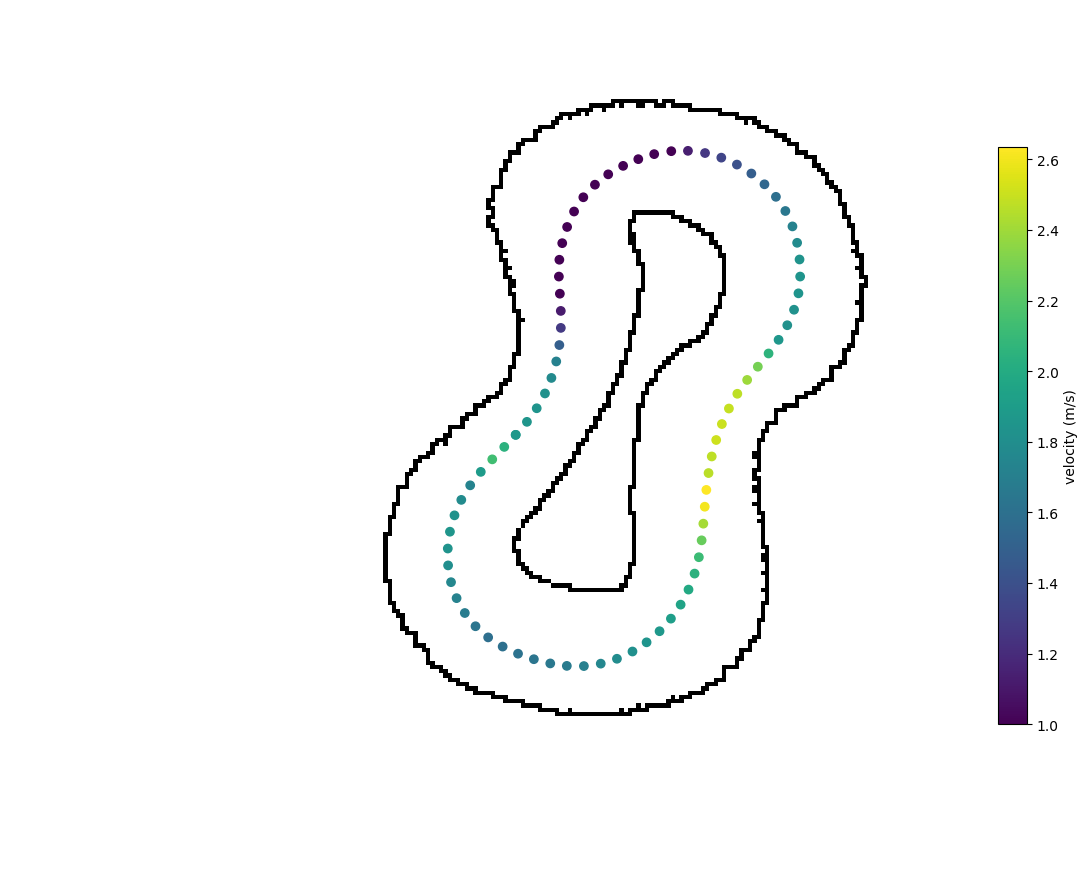

In [20]:
%matplotlib inline
plt.figure(figsize=(15,15))
plt.scatter(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], c=transformed_data.iloc[:, 2])
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('velocity (m/s)')

plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.axis('off')

## (OPTIONAL) Overlay on the original map

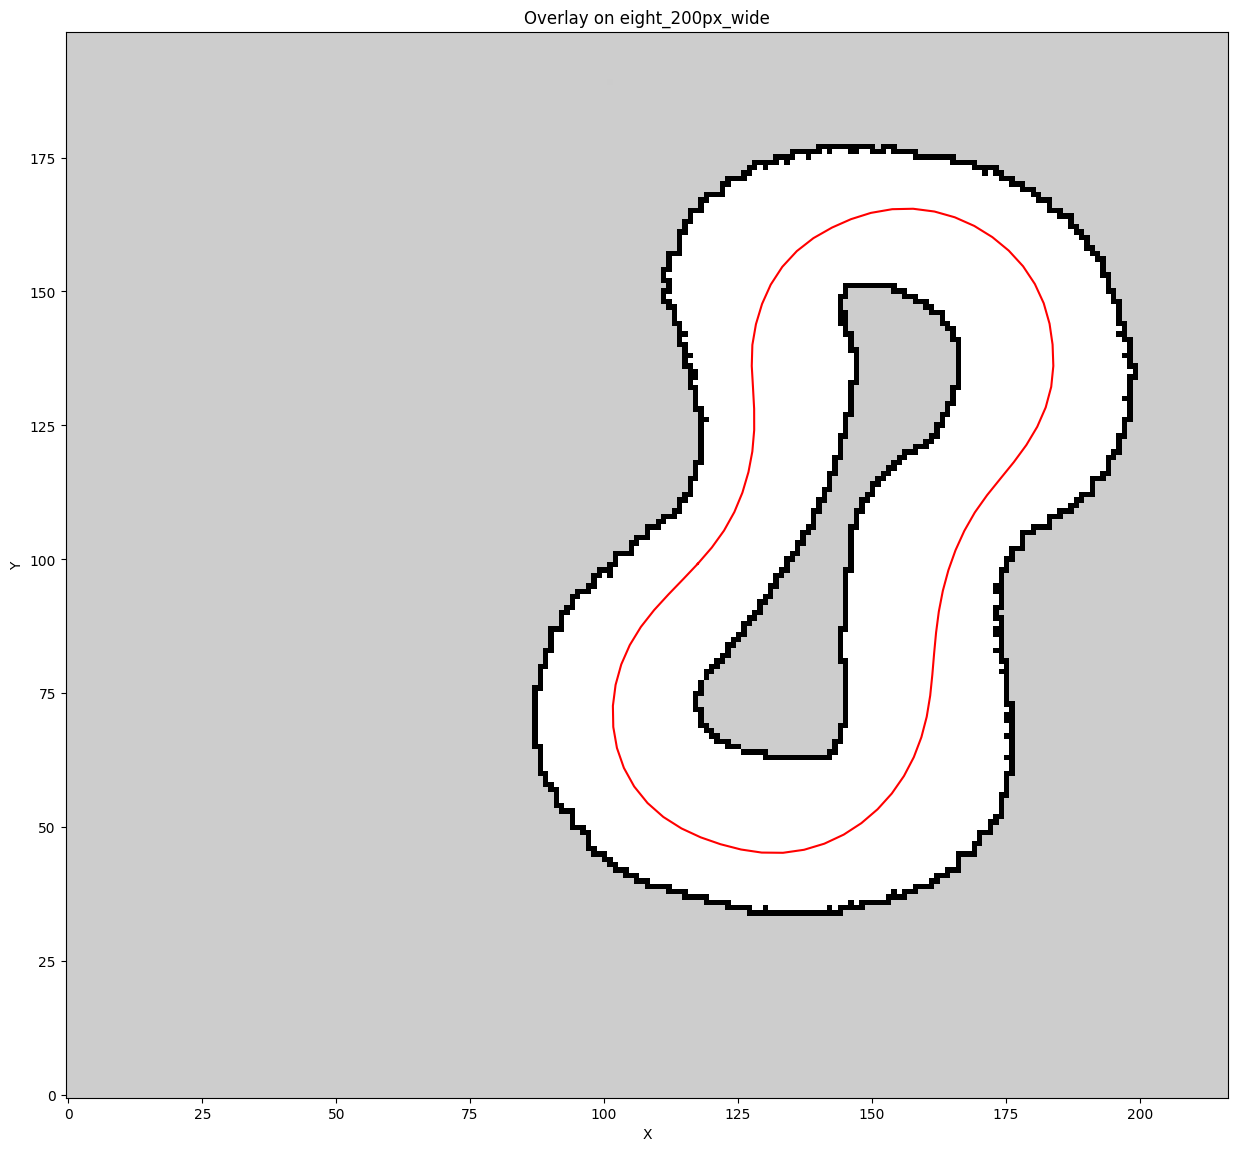

In [21]:
ORIG_MAP = f"{MAP_NAME}"

# Try .png first, then .pgm fallback
if os.path.exists(f"maps/{ORIG_MAP}.png"):
    map_img_path = f"maps/{ORIG_MAP}.png"
elif os.path.exists(f"maps/{ORIG_MAP}.pgm"):
    map_img_path = f"maps/{ORIG_MAP}.pgm"
else:
    raise FileNotFoundError(f"No map image found for {ORIG_MAP} in PNG or PGM format.")

# Load and flip image
orig_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)

# Convert to grayscale if needed
if len(orig_map_img.shape) > 2:
    orig_map_img = orig_map_img[:, :, 0]

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(orig_map_img, cmap='gray', origin='lower')
plt.plot(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], color='red')
plt.title(f"Overlay on {ORIG_MAP}")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


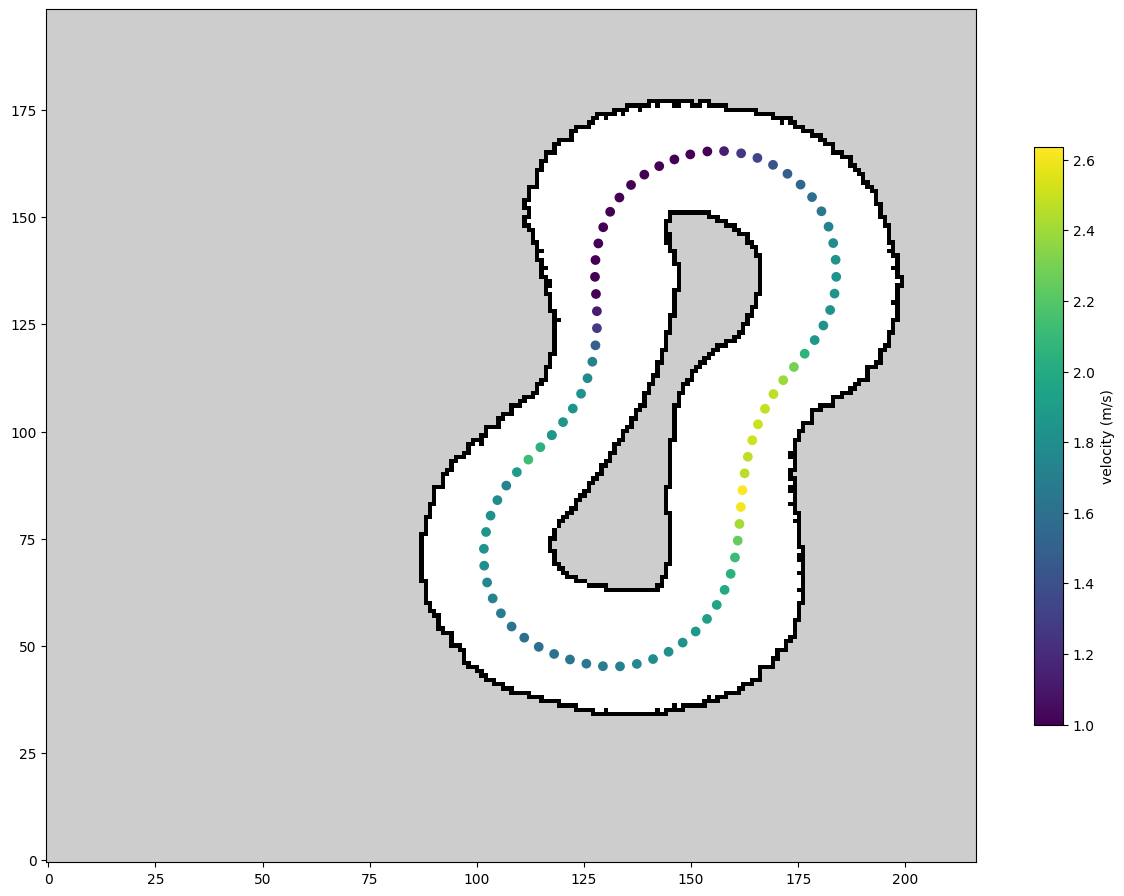

In [22]:
plt.figure(figsize=(15,15))
plt.imshow(orig_map_img, cmap='gray', origin='lower')
plt.scatter(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], c=transformed_data.iloc[:, 2])
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('velocity (m/s)')

## Visualize Velocity Profile in 3D

In [23]:
raw_data_np = transformed_data.to_numpy()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
# Visualize Velocity Profile
scale_x = 1.0
scale_y = 1.0
scale_z = 0.3  # scale z axis such that it does not appear stretched

# create 3d plot

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')

# recast get_proj function to use scaling factors for the axes
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1.0]))

ax.grid()
ax.set_aspect("auto")
ax.set_xlabel("east in m")
ax.set_ylabel("north in m")

# Doesn't work
# import matplotlib
# x,y = np.mgrid[0:orig_map_img.shape[0], 0:orig_map_img.shape[1]]
# ax.plot_surface(x,y,np.sin(0*x), facecolors=matplotlib.cm.ScalarMappable(cmap='gray').to_rgba(orig_map_img))

# plot velocity profile in 3D
ax.plot(raw_data_np[:, 0], raw_data_np[:, 1], raw_data_np[:, 2], color="k")
ax.set_zlabel("velocity in m/s")

# plot vertical lines visualizing acceleration and deceleration zones
ind_stepsize = 1
cur_ind = 0
no_points_traj_vdc = np.shape(raw_data_np)[0]
prev_vel = 0
curr_vel = 0

while cur_ind < no_points_traj_vdc - 1:
	curr_vel = raw_data_np[cur_ind, 2]
	x_tmp = [raw_data_np[cur_ind, 0], raw_data_np[cur_ind, 0]]
	y_tmp = [raw_data_np[cur_ind, 1], raw_data_np[cur_ind, 1]]
	z_tmp = [0.0, curr_vel]  # plot line with height depending on velocity

	# get proper color for line depending on acceleration
	if curr_vel - prev_vel > 0.0:
		col = "g"
	elif curr_vel - prev_vel < 0.0:
		col = "r"
	else:
		col = "gray"
	
	prev_vel = curr_vel

	# plot line
	ax.plot(x_tmp, y_tmp, z_tmp, color=col)

	# increment index
	cur_ind += ind_stepsize


plt.show()

: 